In [1]:
from datetime import datetime, timedelta
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

In [2]:
RANDOM_SEED = 42

In [3]:
data = pd.read_csv('main_task.csv')

In [4]:
data.sample(5)

,Restaurant_id,City,Cuisine Style,Ranking,Rating,Price Range,Number of Reviews,Reviews,URL_TA,ID_TA
38887,id_2198,Berlin,['Italian'],2200.0,4.5,$$ - $$$,11.0,"[['Authentic Italian and excellent', 'Good Ita...",/Restaurant_Review-g187323-d9554512-Reviews-Ri...,d9554512
20136,id_818,Rome,"['Italian', 'Mediterranean', 'Vegetarian Frien...",819.0,4.0,$$$$,788.0,"[['Most Memorable Meal in Rome', 'Excellent!!'...",/Restaurant_Review-g187791-d778316-Reviews-Ost...,d778316
20859,id_310,Warsaw,"['International', 'Spanish']",311.0,5.0,$$ - $$$,26.0,"[['Great place', 'Favorite spot in Warsaw'], [...",/Restaurant_Review-g274856-d9459647-Reviews-Ba...,d9459647
5606,id_3166,Barcelona,"['Spanish', 'Wine Bar']",3167.0,4.5,$,17.0,"[['The real Catalan vermuteriya'], ['09/14/201...",/Restaurant_Review-g187497-d8029212-Reviews-La...,d8029212
15354,id_699,Stockholm,"['Swedish', 'Scandinavian', 'European']",700.0,4.0,$$ - $$$,28.0,"[['Not only for the locals', 'A very good rest...",/Restaurant_Review-g189852-d740154-Reviews-Bra...,d740154


In [5]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 40000 entries, 0 to 39999
Data columns (total 10 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   Restaurant_id      40000 non-null  object 
 1   City               40000 non-null  object 
 2   Cuisine Style      30717 non-null  object 
 3   Ranking            40000 non-null  float64
 4   Rating             40000 non-null  float64
 5   Price Range        26114 non-null  object 
 6   Number of Reviews  37457 non-null  float64
 7   Reviews            40000 non-null  object 
 8   URL_TA             40000 non-null  object 
 9   ID_TA              40000 non-null  object 
dtypes: float64(3), object(7)
memory usage: 3.1+ MB


In [6]:
data.describe()

,Ranking,Rating,Number of Reviews
count,40000.000000,40000.000000,37457.000000
mean,3676.028525,3.993037,124.825480
std,3708.749567,0.668417,295.666352
min,1.000000,1.000000,2.000000
25%,973.000000,3.500000,9.000000
50%,2285.000000,4.000000,33.000000
75%,5260.000000,4.500000,115.000000
max,16444.000000,5.000000,9660.000000


Подробнее по признакам:

City: Город
Cuisine Style: Кухня
Ranking: Ранг ресторана относительно других ресторанов в этом городе
Price Range: Цены в ресторане в 3 категориях
Number of Reviews: Количество отзывов
Reviews: 2 последних отзыва и даты этих отзывов
URL_TA: страница ресторана на 'www.tripadvisor.com'
ID_TA: ID ресторана в TripAdvisor
Rating: Рейтинг ресторана

# Обработка Nan

У наличия пропусков могут быть разные причины, но пропуски нужно либо заполнить, либо исключить из набора полностью. Но с пропусками нужно быть внимательным, даже отсутствие информации может быть важным признаком!
По этому перед обработкой NAN лучше вынести информацию о наличии пропуска как отдельный признак

В признаках 'Number of Reviews', 'Price Range', 'Cuisine Style' есть пропуски. Сделаем отдельную колонку для 'Number of Reviews', чтобы обозначить, где в признаках были пропуски.

Для 'Cuisine Style' и 'Price Range' этого делать не будем, так как в них пропуски будут заполнены отдельным значением.

In [7]:
data['Rev_Number_NAN'] = pd.isna(data['Number of Reviews']).astype('uint8')


In [8]:
# Посмотрим какие признаки у нас могут быть категориальными
data.nunique(dropna=False)

Restaurant_id        11909
City                    31
Cuisine Style         9008
Ranking              11936
Rating                   9
Price Range              4
Number of Reviews     1460
Reviews              33516
URL_TA               39980
ID_TA                39980
Rev_Number_NAN           2
dtype: int64

Видим, что не все id  ресторанов уникальны (возможно, одинаковыми id обозначены рестораны одной сети?).
20 ссылок на страницу ресторана на сайте повторяются.
Возможно, это дубли строк, но в нашем случае удалять нельзя, оставим так.

Дальше пойдем рассматривать признаки отдельно по столбцам

# Restaurant_id

In [9]:
data['Restaurant_id'].value_counts()

id_871      18
id_227      18
id_436      18
id_633      18
id_344      17
            ..
id_7880      1
id_15567     1
id_5444      1
id_10932     1
id_15814     1
Name: Restaurant_id, Length: 11909, dtype: int64

In [10]:
# Предположим, что повторяющиеся id присвоены ресторанам одной сети
# Создадим новый признак "сетевой" - 1, "несетевой" - 0

chain_id = list(data['Restaurant_id'].value_counts()[
                data['Restaurant_id'].value_counts() > 1].index)
data['chain'] = data[data['Restaurant_id'].isin(
    chain_id)]['Restaurant_id'].apply(lambda x: 1)
data['chain'].fillna(0, inplace=True)
data['chain'].value_counts()

1.0    35295
0.0     4705
Name: chain, dtype: int64

# City

In [11]:
data['City'].value_counts()

London        5757
Paris         4897
Madrid        3108
Barcelona     2734
Berlin        2155
Milan         2133
Rome          2078
Prague        1443
Lisbon        1300
Vienna        1166
Amsterdam     1086
Brussels      1060
Hamburg        949
Munich         893
Lyon           892
Stockholm      820
Budapest       816
Warsaw         727
Dublin         673
Copenhagen     659
Athens         628
Edinburgh      596
Zurich         538
Oporto         513
Geneva         481
Krakow         443
Oslo           385
Helsinki       376
Bratislava     301
Luxembourg     210
Ljubljana      183
Name: City, dtype: int64

Зададим столицы и создадим признак "Столица" - 1, "Не столица" - 0. Потом разобьем города на dummy-переменные.

In [12]:
сapitals = ['London', 'Paris', 'Madrid', 'Berlin',
            'Rome', 'Prague', 'Lisbon', 'Vienna',
            'Amsterdam', 'Brussels', 'Stockholm',
            'Budapest', 'Warsaw', 'Dublin', 'Copenhagen',
            'Athens', 'Edinburgh', 'Oslo', 'Helsinki',
            'Bratislava', 'Luxemburg', 'Ljubljana']

data['Сapital'] = data['City'].apply(lambda x: 1 if x in сapitals else 0)

In [13]:
# Создадим признак "Country" и создадим dummy-переменные для стран
country = {
    'Paris': 'France',
    'Hamburg': 'Germany',
    'Rome': 'Italy',
    'London': 'UK',
    'Milan': 'Italy',
    'Madrid': 'Spain',
    'Oslo': 'Norway',
    'Stockholm': 'Sweden',
    'Krakow': 'Poland',
    'Lyon': 'Paris',
    'Lisbon': 'Portugal',
    'Edinburgh': 'UK',
    'Vienna': 'Austria',
    'Warsaw': 'Poland',
    'Amsterdam': 'Netherlands',
    'Budapest': 'Hungary',
    'Helsinki': 'Finland',
    'Zurich': 'Switzerland',
    'Luxembourg': 'Luxembourg',
    'Berlin': 'Germany',
    'Prague': 'Czechia',
    'Munich': 'Germany',
    'Bratislava': 'Slovakia',
    'Brussels': 'Belgium',
    'Ljubljana': 'Slovenia',
    'Copenhagen': 'Denmark',
    'Oporto': 'Portugal',
    'Barcelona': 'Spain',
    'Geneva': 'Switzerland',
    'Athens': 'Greece',
    'Dublin': 'Ireland'
}

data['Country'] = data['City'].map(country)
data = pd.get_dummies(data, columns=['Country'])

In [14]:
data.sample(5)

,Restaurant_id,City,Cuisine Style,Ranking,Rating,Price Range,Number of Reviews,Reviews,URL_TA,ID_TA,...,Country_Norway,Country_Paris,Country_Poland,Country_Portugal,Country_Slovakia,Country_Slovenia,Country_Spain,Country_Sweden,Country_Switzerland,Country_UK
36163,id_3012,Prague,"['European', 'Czech']",3019.0,4.0,NaN,3.0,"[['Great beer, good food.', 'Best burgers, ave...",/Restaurant_Review-g274707-d4768875-Reviews-U_...,d4768875,...,0,0,0,0,0,0,0,0,0,0
5884,id_580,Lyon,NaN,581.0,4.5,NaN,25.0,"[['Great place for a drink by the river', 'Per...",/Restaurant_Review-g187265-d10622010-Reviews-V...,d10622010,...,0,1,0,0,0,0,0,0,0,0
3783,id_4172,Berlin,['International'],4174.0,4.5,NaN,5.0,[['Hiding in plain sight - secret restaurant.....,/Restaurant_Review-g187323-d2621534-Reviews-S_...,d2621534,...,0,0,0,0,0,0,0,0,0,0
32728,id_740,Lyon,"['Asian', 'Vietnamese', 'Soups', 'Vegetarian F...",741.0,4.5,$,49.0,"[['Outstanding Vietnamese fare', 'Good chicken...",/Restaurant_Review-g187265-d4123786-Reviews-Na...,d4123786,...,0,1,0,0,0,0,0,0,0,0
33196,id_373,Stockholm,"['Asian', 'Vegetarian Friendly', 'Vegan Options']",374.0,4.0,$$ - $$$,70.0,"[['Better than expected', 'Wish This Was an In...",/Restaurant_Review-g189852-d8633540-Reviews-Ba...,d8633540,...,0,0,0,0,0,0,0,1,0,0


In [15]:
# Разобьем города на dummy-переменные
data = pd.get_dummies(data, columns=['City'])

# Cuisine Style

Создадим список уникальных кухонь представленных во всем датасете. Пропуски заполним значением 'Unknown'. Создадим признак 'cuisine_count' - количество кухонь в каждом ресторане.

In [16]:
data['Cuisine Style'].fillna("['Unknown']", inplace=True)
data['Cuisine Style'] = data['Cuisine Style'].apply(lambda x: eval(x))

data['cuisine_count'] = data['Cuisine Style'].apply(lambda x: len(x))

cuisine_list = []
for cuisines in data['Cuisine Style']:
    for cuisine in cuisines:
        cuisine_list.append(cuisine)

cuisine_dict = {}
for cuisine in cuisine_list:
    if cuisine in cuisine_dict:
        continue
    else:
        cuisine_dict[cuisine] = 0

for cuisine in cuisine_list:
    cuisine_dict[cuisine] += 1

len(cuisine_dict)

126

In [17]:
cuisine_dict

{'European': 10060,
 'French': 3190,
 'International': 1584,
 'Unknown': 9283,
 'Japanese': 1464,
 'Sushi': 1156,
 'Asian': 3011,
 'Grill': 490,
 'Vegetarian Friendly': 11189,
 'Vegan Options': 4486,
 'Gluten Free Options': 4113,
 'German': 662,
 'Central European': 1393,
 'Italian': 5964,
 'Pizza': 2849,
 'Fast Food': 1705,
 'Mediterranean': 6277,
 'Spanish': 2798,
 'Healthy': 620,
 'Cafe': 2325,
 'Thai': 743,
 'Vietnamese': 513,
 'Bar': 3297,
 'Pub': 2449,
 'Chinese': 1145,
 'British': 1595,
 'Polish': 365,
 'Fusion': 577,
 'Dutch': 294,
 'Mexican': 445,
 'Venezuelan': 40,
 'South American': 372,
 'Soups': 494,
 'Belgian': 270,
 'Steakhouse': 573,
 'Latin': 302,
 'Barbecue': 555,
 'Argentinean': 169,
 'Irish': 284,
 'Seafood': 1505,
 'Swiss': 178,
 'Portuguese': 1107,
 'Contemporary': 523,
 'Wine Bar': 697,
 'Greek': 604,
 'Central American': 135,
 'Indian': 1041,
 'Middle Eastern': 782,
 'Turkish': 444,
 'Hungarian': 352,
 'Pakistani': 123,
 'Peruvian': 94,
 'Delicatessen': 392,
 'E

In [18]:
# Создадим список кухонь, которые встречаются чаще, чем заданное количество раз,
# которое можно варьировать и смотреть, как это влияет на оценку.
# Зададим это число равным 2500

cuisine_limit = 2500
frequent_cuisine = []
for cuisine, number in cuisine_dict.items():
    if number > cuisine_limit:
        frequent_cuisine.append(cuisine)

len(frequent_cuisine)

12

Как показала работа модели, тип кухни не сильно влияет на предсказание, поэтому я оставила только примерно 10 % самых популярных кухонь.

In [19]:
# все нечастые кухни заменим на "Other"
data['Cuisine Style'] = data['Cuisine Style'].map(lambda x: list(
    set([i if i in frequent_cuisine else 'Other' for i in x])))

Создадим dummy переменные кухонь

In [20]:
# Создадим dummy переменные кухонь

def find_item(cell):
    if item in cell:
        return 1
    return 0


for item in frequent_cuisine:
    data[item] = data['Cuisine Style'].apply(find_item)

# Ranking

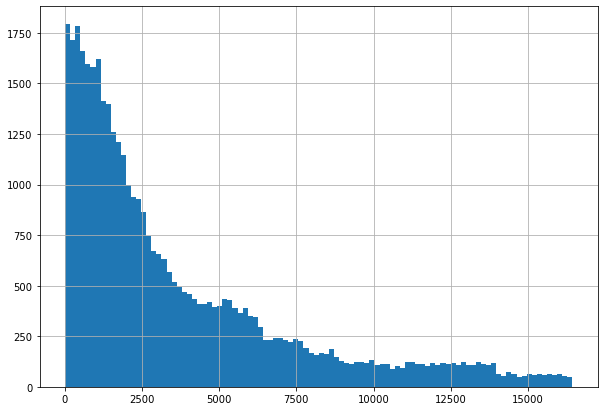

In [21]:
plt.rcParams['figure.figsize'] = (10, 7)
data['Ranking'].hist(bins=100)

In [22]:
data['Ranking'].describe()

count    40000.000000
mean      3676.028525
std       3708.749567
min          1.000000
25%        973.000000
50%       2285.000000
75%       5260.000000
max      16444.000000
Name: Ranking, dtype: float64

Разброс большой, проведем нормализацию

In [23]:
scaler = MinMaxScaler()
data['Norm_Ranking'] = scaler.fit_transform(pd.DataFrame(data['Ranking']))

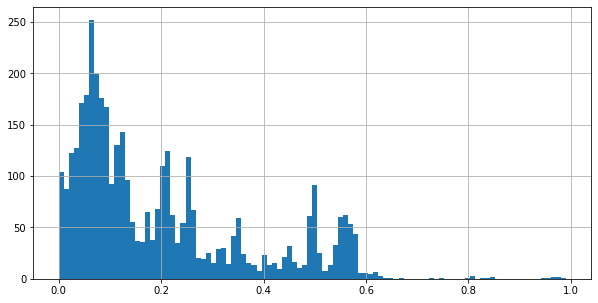

In [24]:
# Посмотрим распределение целевой переменной относительно признака Norm_Ranking

plt.figure(figsize=(10, 5))
data['Norm_Ranking'][data['Rating'] == 5].hist(bins=100)

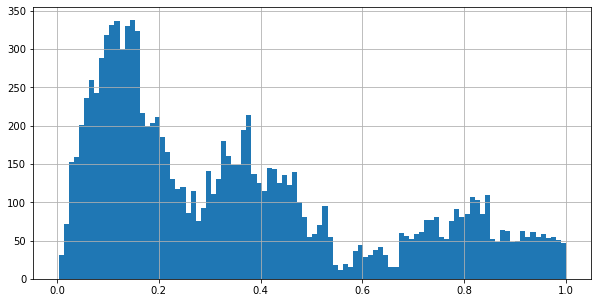

In [25]:
plt.figure(figsize=(10, 5))
data['Norm_Ranking'][data['Rating'] < 4].hist(bins=100)

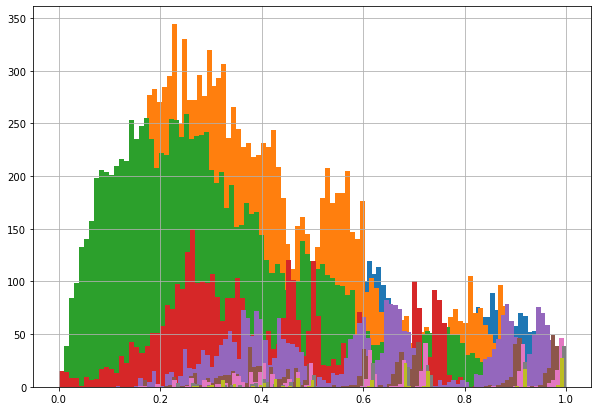

In [26]:
# Посмтрим распределение рейтинга в зависимости от ранга

for x in data.Rating.unique():
    np.sqrt(data['Norm_Ranking'][data['Rating'] == x]).hist(bins=100)

# Rating

Проверим, что в рейтинге все значения находятся в пределах 0-5

In [27]:
data['Rating'].value_counts()  # Выбросов нет

4.0    13692
4.5    10929
3.5     6824
5.0     3879
3.0     2955
2.5      915
2.0      466
1.0      201
1.5      139
Name: Rating, dtype: int64

# Price Range

In [28]:
data['Price Range'].value_counts()

$$ - $$$    18412
$            6279
$$$$         1423
Name: Price Range, dtype: int64

In [29]:
# Заполним пропуски нулями.
data['Price Range'].fillna(0, inplace=True)

# Присваиваем категории ценовым диапазонам
# '$' - 1
# '$$ - $$$' - 2
# '$$$$' - 3
data['Price Range'] = data['Price Range'].replace(['$'], '1')
data['Price Range'] = data['Price Range'].replace(['$$ - $$$'], '2')
data['Price Range'] = data['Price Range'].replace(['$$$$'], '3')

data['Price Range'] = data['Price Range'].astype('float64')

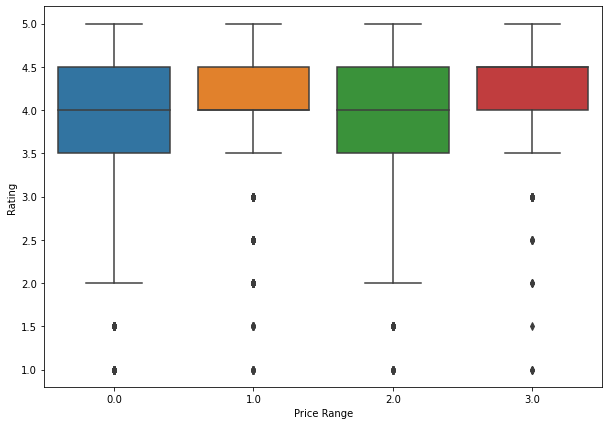

In [30]:
sns.boxplot(x='Price Range', y='Rating', data=data)

Видно, что у дорогих ресторанов разброс рейтинга поменьше 

# Number of Reviews

In [31]:
# Посмотрим, есть ли закономерность по пропускам
data[data['Number of Reviews'].isna()]

,Restaurant_id,Cuisine Style,Ranking,Rating,Price Range,Number of Reviews,Reviews,URL_TA,ID_TA,Rev_Number_NAN,...,Asian,Vegetarian Friendly,Vegan Options,Gluten Free Options,Italian,Pizza,Mediterranean,Spanish,Bar,Norm_Ranking
8,id_2690,[Unknown],2692.0,4.0,0.0,NaN,"[[], []]",/Restaurant_Review-g190454-d12845029-Reviews-G...,d12845029,1,...,0,0,0,0,0,0,0,0,0,0.163656
21,id_5844,[Unknown],5847.0,4.0,0.0,NaN,"[[], []]",/Restaurant_Review-g187514-d10058810-Reviews-B...,d10058810,1,...,0,0,0,0,0,0,0,0,0,0.355531
32,id_1327,[Unknown],1328.0,5.0,0.0,NaN,"[['Absolutely amazing, tasty, fresh, cheap Ch....",/Restaurant_Review-g274887-d8791087-Reviews-Bu...,d8791087,1,...,0,0,0,0,0,0,0,0,0,0.080703
102,id_1409,"[European, French, Other]",1410.0,5.0,0.0,NaN,"[[], []]",/Restaurant_Review-g274887-d13197631-Reviews-L...,d13197631,1,...,0,0,0,0,0,0,0,0,0,0.085690
108,id_2047,"[Italian, Mediterranean]",2050.0,5.0,2.0,NaN,"[[], []]",/Restaurant_Review-g274707-d12243659-Reviews-T...,d12243659,1,...,0,0,0,0,1,0,1,0,0,0.124612
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
39965,id_5720,[Unknown],5722.0,5.0,0.0,NaN,"[[], []]",/Restaurant_Review-g187791-d793376-Reviews-Wes...,d793376,1,...,0,0,0,0,0,0,0,0,0,0.347929
39972,id_2009,[Other],2012.0,5.0,1.0,NaN,"[['Personal expirence'], ['10/27/2017']]",/Restaurant_Review-g274707-d12981295-Reviews-M...,d12981295,1,...,0,0,0,0,0,0,0,0,0,0.122301
39986,id_7274,[Unknown],7279.0,3.0,0.0,NaN,"[[], []]",/Restaurant_Review-g187514-d12182212-Reviews-C...,d12182212,1,...,0,0,0,0,0,0,0,0,0,0.442620
39988,id_4968,[Unknown],4970.0,4.0,0.0,NaN,"[[], []]",/Restaurant_Review-g187323-d7761701-Reviews-Ar...,d7761701,1,...,0,0,0,0,0,0,0,0,0,0.302195


Пропуски там, где нет отзывов в 'Reviews' или 1 отзыв. Так как максимум в этой колонке 9660, то нет большой разницы, будем мы заполнять ее 0 или 1. Заполним пропуски нулями.

In [32]:
data['Number of Reviews'].fillna(0, inplace=True)

# Reviews

Колонка имеет структуру списка списков [['отзыв', 'отзыв'], ['дата', 'дата']], но тип - строка

In [33]:
# заменим пропуски
data['Reviews'] = data['Reviews'].fillna("[['', ''], ['', '']]")

Найдем строки, на которых происходит сбой:

In [34]:
for Review in data['Reviews']:
    try:
        temp = eval(Review)
    except:
        print(Review)

[['Will certainly be back', nan], ['11/26/2017', '07/27/2017']]
[[nan, 'Good food with decent service'], ['11/21/2017', '07/21/2017']]


Заменим все "неправильные" значения, заодно заменим [[], []] на [['', ''], ['', '']]. Переведем строку в список.

In [35]:
data['Reviews'] = data['Reviews'].apply(lambda x: x.replace(
    'nan', '').replace("[,", "['',").replace('[[], []]', "[['', ''], ['', '']]"))
data['Reviews'] = data['Reviews'].apply(lambda x: eval(x))

Разнесем даты и отзывы по отдельным колонкам:

In [36]:
data['Review_1'] = data['Reviews'].apply(lambda x: x[0][0])
data['Review_2'] = data['Reviews'].apply(
    lambda x: x[0][1] if len(x[0]) == 2 else '')
data['date_1'] = data['Reviews'].apply(lambda x: x[1][0])
data['date_2'] = data['Reviews'].apply(
    lambda x: x[1][1] if len(x[1]) == 2 else '')
data['date_1'] = pd.to_datetime(data['date_1'])
data['date_2'] = pd.to_datetime(data['date_2'])

Найдем самую раннюю дату во всем датафрейме и заполним ею пропуски.

In [37]:
min_date = min(data['date_1'].min(), data['date_2'].min())
data['date_1'] = data['date_1'].fillna(min_date)
data['date_2'] = data['date_2'].fillna(min_date)

In [38]:
# Минимальное количество дней от текущей даты до последнего отзыва:
now = datetime.today()
data['time_delta'] = data[['date_1', 'date_1']].max(
    axis=1).apply(lambda x: (now-x).days)

In [39]:
# Количество дней между отзывами
data['review_time_delta'] = abs((data['date_1'] - data['date_2']).dt.days)

In [40]:
# Удалим ненужные столбцы
data.drop(['Restaurant_id', 'Cuisine Style', 'Ranking', 'Reviews', 'URL_TA',
           'Review_1', 'Review_2', 'date_1', 'date_2', 'ID_TA'], axis=1, inplace=True)

In [41]:
data.head(3)

,Rating,Price Range,Number of Reviews,Rev_Number_NAN,chain,Сapital,Country_Austria,Country_Belgium,Country_Czechia,Country_Denmark,...,Vegan Options,Gluten Free Options,Italian,Pizza,Mediterranean,Spanish,Bar,Norm_Ranking,time_delta,review_time_delta
0,3.5,2.0,194.0,0,1.0,1,0,0,0,0,...,0,0,0,0,0,0,0,0.338685,1108,41
1,4.0,0.0,10.0,0,1.0,1,0,0,0,0,...,0,0,0,0,0,0,0,0.093414,1286,382
2,4.5,3.0,688.0,0,1.0,1,0,0,0,0,...,1,1,0,0,0,0,0,0.021407,1100,2


# Кореляция признаков

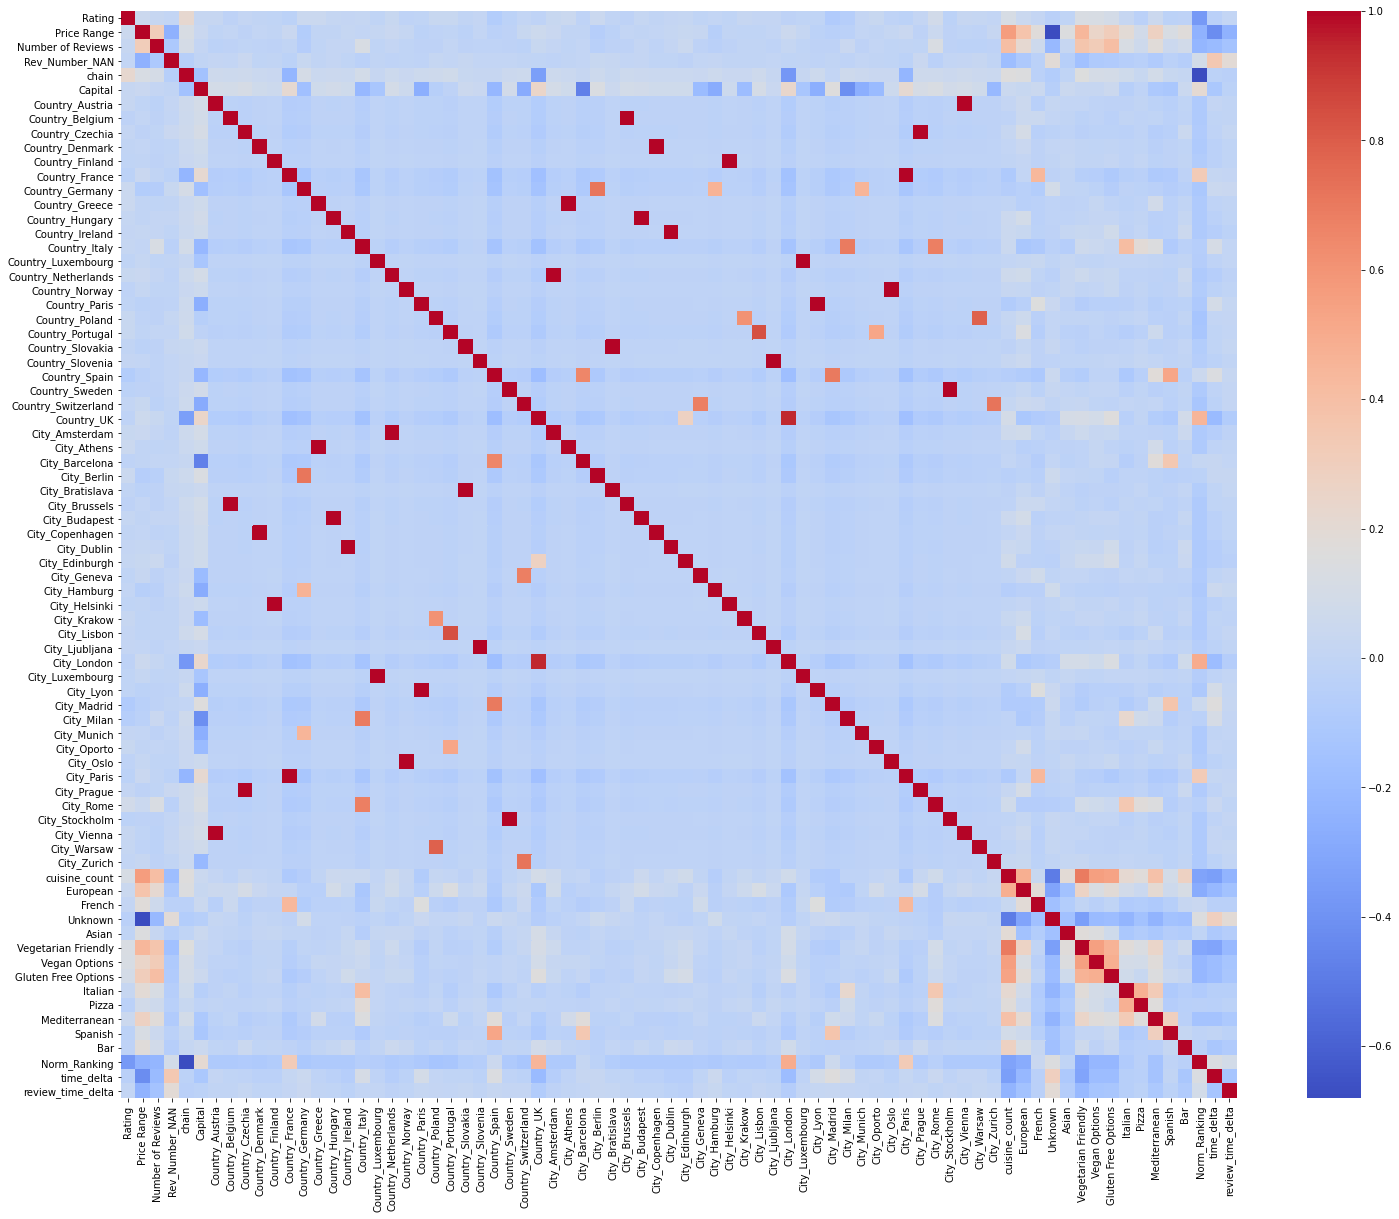

In [42]:
plt.rcParams['figure.figsize'] = (25, 20)
correlation = data.corr()
sns.heatmap(correlation, cmap='coolwarm')

In [43]:
# Х - данные с информацией о ресторанах, у - целевая переменная (рейтинги ресторанов)
X = data.drop(['Rating'], axis=1)
y = data['Rating']

In [44]:
# Наборы данных с меткой "train" будут использоваться для обучения модели, "test" - для тестирования.
# Для тестирования мы будем использовать 25% от исходного датасета.
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.25, random_state=RANDOM_SEED)

In [45]:
# Импортируем необходимые библиотеки:
# инструмент для создания и обучения модели
from sklearn.ensemble import RandomForestRegressor
from sklearn import metrics  # инструменты для оценки точности модели

In [46]:
# Создаём модель
regr = RandomForestRegressor(n_estimators=100, random_state=RANDOM_SEED)

# Обучаем модель на тестовом наборе данных
regr.fit(X_train, y_train)

# Используем обученную модель для предсказания рейтинга ресторанов в тестовой выборке.
# Предсказанные значения записываем в переменную y_pred
y_pred = regr.predict(X_test)

In [47]:
# Сравниваем предсказанные значения (y_pred) с реальными (y_test), и смотрим насколько они в среднем отличаются
# Метрика называется Mean Absolute Error (MAE) и показывает среднее отклонение предсказанных значений от фактических.
print('MAE:', metrics.mean_absolute_error(y_test, y_pred))

MAE: 0.20983800000000002
